Google collab link : https://colab.research.google.com/drive/1oEV5L9yo7n-BFVZP783sauIqqvi2Q86z?usp=sharing

Import libraries and setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import Dataset
from typing import Type
import matplotlib.pyplot as plt
from time import time

plt.rcParams['figure.figsize'] = (9, 6) # Make plots bigger
cmap = plt.get_cmap('jet_r')  # For getting colors of lines plotted

Set seed

In [ ]:
# set seed for reproducibility
SEED = 1857602
np.random.seed(SEED)
torch.manual_seed(SEED)

Apparently this might make things faster

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Load datasets

In [ ]:
MNIST_train_set = torchvision.datasets.MNIST(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor()])
)

MNIST_test_set = torchvision.datasets.MNIST(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor()])
)


In [ ]:
CIFAR10_train_set = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor()])
)

CIFAR10_test_set = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor()])
)


Files already downloaded and verified
Files already downloaded and verified


## Task 1: Implement a fully-connected neural network 

In [ ]:
class Net(nn.Module):
    def __init__(self, dim, nclass, width, depth):
        """
        Class for neural network

        Attributes:
        -----------
        dim : Dimension of input, int
        nclass : Number of output classes, int
        width : Width of each layer, int
        depth : Depth of the network, int
        """
        super().__init__()

        # Attributes
        self.dim = dim
        self.nclass = nclass
        self.width = width
        self.depth = depth

        # Layers
        self.flatten = nn.Flatten()
        self.input_hidden = nn.Linear(dim, width)
        # Collection of depth - 1 layers which go from hidden to hidden
        self.hidden_hidden_layers = nn.ModuleList([nn.Linear(width, width) for i in range(self.depth - 1)])
        self.hidden_output = nn.Linear(width, nclass)
        self.relu = nn.ReLU()
    
    def forward(self, input):
        """
        Pass input through hidden layers and return the output
        """

        # Flatten then pass input through first hidden layer
        x = self.flatten(input)
        x = self.input_hidden(x)
        x = self.relu(x)

        # Pass through depth - 1 hidden layers
        for layer in self.hidden_hidden_layers:
            x = layer(x)
            x = self.relu(x)
        
        # Pass through last hidden layer
        x = self.hidden_output(x)
        return x

##Task 2: Implement the data loading function

In [ ]:
def loading_data(batch_size, train_set, test_set):
    "Return train and test DataLoader objects of the corresponding batch size with shuffle enabled."

    trainloader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=True)
    return trainloader, testloader

##Task 3: Implement a function that does one training epoch

In [ ]:
def train_epoch(trainloader, net, optimizer, criterion):
    "Executes one training epoch. Returns average loss over train data."

    total_loss = 0
    ntrain = 0 # Number of training inputs
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)

        # Make predictions with net
        predictions = net(X)
        
        # Compute loss
        loss = criterion(predictions, y)
        # Increment total loss
        batch_avg_loss = loss.item()  # By default returns average across the batch
        total_loss += batch_avg_loss * len(X)
        
        # Back propagation
        optimizer.zero_grad()   # Reset optimizer gradient
        loss.backward()         # Compute gradient of loss
        optimizer.step()        # Update parameters by performing one step in optimizer

        ntrain += X.shape[0]
    return total_loss / ntrain

##Task 4: Implement a function that does one test epoch

In [ ]:
@torch.no_grad()  # No gradient computation needed. Should make things faster.
def test_epoch(testloader, net, criterion):
    "Executes one test epoch. Returns (Average loss, incorrect count)"
    
    total_loss = 0
    incorrect_count = 0
    ntrain = 0

    # Iterate over test data
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        predictions = net(X)

        # Compute loss
        loss = criterion(predictions, y)
        # Increment total loss
        batch_avg_loss = loss.item()
        total_loss += batch_avg_loss * len(X)

        # Number of correct predictions
        pred_labels = torch.max(predictions, dim=1)[1] # Predicted labels
        bool_arr = pred_labels != y
        incorrect_count += sum(bool_arr)
        ntrain += X.shape[0]

    avg_loss = total_loss / ntrain
    return avg_loss, incorrect_count

## Task 5: Write a piece of code that sets the hyperparameters and that allows to run the train and test epochs

In [ ]:
def train_1(
    batch_size : int,
    dim : int,
    nclass : int,
    width : int,
    depth : int,
    lr : float,
    nepochs : int,
    criterion : callable,
    optimizer_class : Type[torch.optim.Optimizer],
    train_set : Dataset,
    test_set : Dataset,
    output : str,
    print_freq : int,
    dp : int,
    trunc : float,
    conv_ratio : float,
    **optim_kwargs
    ):
    """
    Train a fully-connected neural network and reports the loss and error on each epoch. Returns the trained net.

    Parameters:
    -----------
    batch_size : How many samples per epoch
    dim : Dimension of flattened input
    nclass : Number of classes
    width : Width of each layer
    depth : Depth of net
    lr : Learning rate
    nepochs : Number of training epochs
    criterion : Loss Function
    optimizer_class : Class of optimizer used
    train_set : Training data
    test_set : Test data
    output : What the function returns
    print_freq : Prints errors every print_freq epochs
    dp : Number of decimal places to print,
    trunc : Early stopping of training if training error < trunc
    conv_ratio : Early stopping by looking at the last 3 train loss.
    If they are at most conv_ratio * m away from m, where m is the mean 
    of the 3 samples, stop the training
    optim_kwargs : Additional arguments to pass into optimizer
    """    
    # Set seed whenever train is called to ensure reproducibility
    SEED = 1857602
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    
    # Initialise the net
    net = Net(dim, nclass, width, depth).to(device=device)

    # Initialise the optimizer
    optimizer = optimizer_class(net.parameters(), lr=lr, **optim_kwargs)

    # Construct data loaders
    trainloader, testloader = loading_data(batch_size, train_set, test_set)

    # Array for storing results
    train_loss_arr, test_loss_arr, test_error_arr = [], [], []

    for epoch in range(nepochs):
        # Train net and store loss over train data
        epoch_train_loss = train_epoch(trainloader, net, optimizer, criterion)

        # Test net and test info
        epoch_test_loss, epoch_incorrect_count = test_epoch(testloader, net, criterion)
        # Compute error rate
        epoch_test_error = epoch_incorrect_count / len(test_set)

        if (print_freq > 0 and (epoch + 1) % print_freq == 0) or epoch == nepochs - 1:
          print(f"Epoch: {round(epoch + 1, dp)} | Train Loss: {round(epoch_train_loss, dp)} | "
                f"Test Loss: {round(epoch_test_loss, dp)} | Test Error: {round(epoch_test_error.item(), dp)}")
        
        # Store results
        train_loss_arr.append(epoch_train_loss)
        test_loss_arr.append(epoch_test_loss)
        test_error_arr.append(epoch_test_error)

        # Stop training early to save computation time
        if epoch + 1 >= 3:
          temp = np.array(train_loss_arr[-3:])
          m = temp.mean()
          max_deviation = max(abs(temp - m))
          if max_deviation / m < conv_ratio:
            break
        if epoch_train_loss < trunc:
          print(f"Epoch: {round(epoch + 1, dp)} | Train Loss: {round(epoch_train_loss, dp)} | "
                f"Test Loss: {round(epoch_test_loss, dp)} | Test Error: {round(epoch_test_error.item(), dp)}")
          break
        
    # Return net only
    if output == "net":
      return net

    # Return errors only
    elif output == "errors":
      return train_loss_arr, test_loss_arr, test_error_arr
    
    # Return both
    elif output == "all":
      return net, train_loss_arr, test_loss_arr, test_error_arr
    
    elif output is None:
      return
    

Wrap the function so some parameters are specified automatically.

In [ ]:
def train(batch_size, width, depth, lr, nepochs, optimizer=optim.Adam, dataset="MNIST", output="errors", print_freq=1, dp=3, trunc=0, conv_ratio = 0, **optim_kwargs):
    nclass = 10
    if dataset == "MNIST":
        dim = 28**2
        train_set, test_set = MNIST_train_set, MNIST_test_set
        
    elif dataset == "CIFAR10":
        dim = 3072
        train_set, test_set = CIFAR10_train_set, CIFAR10_test_set
    else:
        dim = 3072
        train_set, test_set = dataset
      
    
    criterion = torch.nn.CrossEntropyLoss()
    return train_1(batch_size, dim, nclass, width, depth, lr, nepochs, criterion, optimizer, train_set, test_set, output, print_freq, dp, trunc, conv_ratio, **optim_kwargs)

  Train one net as an example. Hyperparameters : 
1. batch_size : 1024
2. width : 512
3. depth : 4
4. learning rate : 0.005
5. nepochs : 5

In [ ]:
train(batch_size=1024, width=512, depth=4, lr=0.005, nepochs=5, print_freq=1, output=None)

Epoch: 1 | Train Loss: 0.555 | Test Loss: 0.154 | Test Error: 0.046
Epoch: 2 | Train Loss: 0.118 | Test Loss: 0.107 | Test Error: 0.033
Epoch: 3 | Train Loss: 0.077 | Test Loss: 0.089 | Test Error: 0.027
Epoch: 4 | Train Loss: 0.066 | Test Loss: 0.085 | Test Error: 0.024
Epoch: 5 | Train Loss: 0.047 | Test Loss: 0.082 | Test Error: 0.023


## Part II: Numerical exploration [10 points]


##Task 6: Analyse the performance for wide vs. deep neural networks
Hyperparameters:
1. batch_size : 512
2. width : 256
3. depth : depth
4. learning rate : 0.0005
5. nepochs : 40


In [ ]:
def task_6(depths):
  train_loss_series_arr = []
  test_loss_series_arr = []

  for depth in depths:
    print(f"Current depth: {depth}\n")
    train_loss, test_loss, test_error = train(batch_size=512, width=256, depth=depth, lr=0.0005, nepochs=40, print_freq=10)
    train_loss_series_arr.append(train_loss)
    test_loss_series_arr.append(test_loss)
    print("\n")

  return train_loss_series_arr, test_loss_series_arr

In [ ]:
depths = [10, 5, 1]
t6_train_loss_series_arr, t6_test_loss_series_arr = task_6(depths)

Current depth: 10

Epoch: 10 | Train Loss: 0.067 | Test Loss: 0.126 | Test Error: 0.034
Epoch: 20 | Train Loss: 0.026 | Test Loss: 0.118 | Test Error: 0.025
Epoch: 30 | Train Loss: 0.014 | Test Loss: 0.132 | Test Error: 0.025
Epoch: 40 | Train Loss: 0.007 | Test Loss: 0.141 | Test Error: 0.023


Current depth: 5

Epoch: 10 | Train Loss: 0.047 | Test Loss: 0.1 | Test Error: 0.029
Epoch: 20 | Train Loss: 0.012 | Test Loss: 0.117 | Test Error: 0.025
Epoch: 30 | Train Loss: 0.003 | Test Loss: 0.137 | Test Error: 0.022
Epoch: 40 | Train Loss: 0.003 | Test Loss: 0.133 | Test Error: 0.022


Current depth: 1

Epoch: 10 | Train Loss: 0.109 | Test Loss: 0.115 | Test Error: 0.034
Epoch: 20 | Train Loss: 0.051 | Test Loss: 0.077 | Test Error: 0.023
Epoch: 30 | Train Loss: 0.026 | Test Loss: 0.065 | Test Error: 0.021
Epoch: 40 | Train Loss: 0.013 | Test Loss: 0.067 | Test Error: 0.022




| Depth | Train Loss | Test Loss |
| --- | --- | --- |
| 1 | 0.013 | 0.067 |
|5|0.003|0.133
 |10|0.007|0.141



Plot train loss

In [ ]:
def plot_loss(series_arr, var_arr, label, title):
  for ind, arr in enumerate(series_arr):
    color = cmap(float(ind) / len(series_arr))
    plt.plot(np.arange(1, len(arr) + 1), arr, label=f"{label}={var_arr[ind]}", linestyle="-", c=color)
    
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.title(title)
  plt.show()


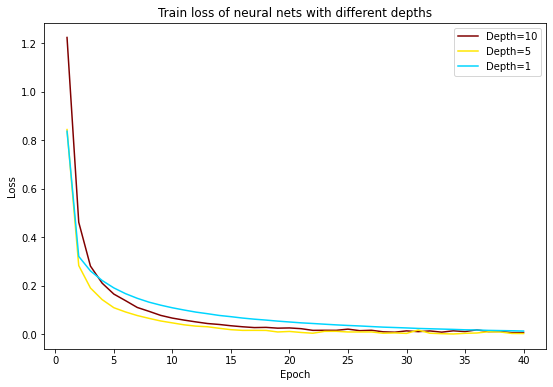

In [ ]:
plot_loss(t6_train_loss_series_arr, var_arr=depths, label="Depth", title="Train loss of neural nets with different depths")

We notice a number of trends in the train loss.


1.   The train loss of depth 1 decreases the slowest. This may be because the model has less parameters. This means that on each update of the gradient descent, generally speaking, the parameters move a smaller distance in the parameter space despite having the same learning rate. (This is because an arbitrary vector of length 1 has, on average, shorter length than one of length 5). Hence, it may be slower to navigate the parameter space to find parameters which give low test loss

2.   The train loss of depth 5 decays faster than that of depth 10. This may be because it is more difficult to optimise the loss function in higher dimensions. This may be because the parameter space is a lot larger.

3. It seems like depth 5 and 10 exhibit more "wiggly" behaviour, which may suggest that they are more difficult to train and require a smaller learning rate to converge. This will be further explored below.

Plot test loss

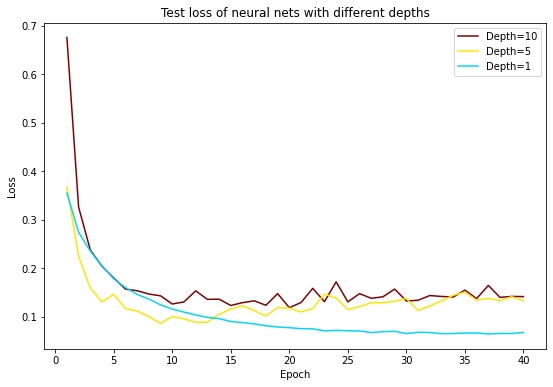

In [ ]:
plot_loss(t6_test_loss_series_arr, var_arr=depths, label="Depth", title="Test loss of neural nets with different depths")

We notice that depth 5 and 10 exhibit quite different behaviour to depth 1.

1. The former exhibit a lot more jumps. This may correspond to the parameters jumping from one approximate local minimum to another. This may be because in higher dimensions, which are the case in depth 5 or 10, approximate local minima have more directions for the parameters to escape from.

2. Depth 5 and 10 converge to higher test loss. They have higher generalisation error

| Depth | Train Loss | Test Loss | Test loss - train loss |
| --- | --- | --- | --- |
| 1 | 0.013 | 0.067 |0.054
|5|0.003|0.133 | 0.130
 |10|0.007|0.141 | 0.134



This is most likely due to overfitting. When we are given more parameters, our models become more complex and exhibit more variance. This may cause our concentration bounds, which we use to bound the difference between the true risk and the empirical risk, to be less effective.

## Task 7: Compare SGD with small and large learning rates

Hyperparameters:
1. batch_size : 8
2. width : 256
3. depth : 1
4. learning rate : learning rate
5. nepochs : 25

In [ ]:
def task_7(lrs):
  lrs = [0.001, 0.01, 0.1]
  train_loss_series_arr = []
  test_loss_series_arr = []

  for lr in lrs:
    print(f"Current learning rate: {lr}\n")
    train_loss, test_loss, test_error = train(batch_size=8, width=256, depth=1, lr=lr, nepochs=25, print_freq=5, optimizer=optim.SGD)
    train_loss_series_arr.append(train_loss)
    test_loss_series_arr.append(test_loss)
    print("\n")
  
  return train_loss_series_arr, test_loss_series_arr

In [ ]:
learning_rates = [0.001, 0.01, 0.1]
t7_train_loss_series_arr, t7_test_loss_series_arr = task_7(learning_rates)

Current learning rate: 0.001

Epoch: 5 | Train Loss: 0.348 | Test Loss: 0.32 | Test Error: 0.09
Epoch: 10 | Train Loss: 0.279 | Test Loss: 0.264 | Test Error: 0.074
Epoch: 15 | Train Loss: 0.237 | Test Loss: 0.227 | Test Error: 0.064
Epoch: 20 | Train Loss: 0.205 | Test Loss: 0.198 | Test Error: 0.057
Epoch: 25 | Train Loss: 0.18 | Test Loss: 0.177 | Test Error: 0.051


Current learning rate: 0.01

Epoch: 5 | Train Loss: 0.123 | Test Loss: 0.116 | Test Error: 0.034
Epoch: 10 | Train Loss: 0.067 | Test Loss: 0.083 | Test Error: 0.025
Epoch: 15 | Train Loss: 0.044 | Test Loss: 0.07 | Test Error: 0.021
Epoch: 20 | Train Loss: 0.03 | Test Loss: 0.062 | Test Error: 0.019
Epoch: 25 | Train Loss: 0.022 | Test Loss: 0.062 | Test Error: 0.019


Current learning rate: 0.1

Epoch: 5 | Train Loss: 0.035 | Test Loss: 0.067 | Test Error: 0.02
Epoch: 10 | Train Loss: 0.005 | Test Loss: 0.068 | Test Error: 0.017
Epoch: 15 | Train Loss: 0.001 | Test Loss: 0.065 | Test Error: 0.016
Epoch: 20 | Train Los

| Learning rate | Train Loss | Test Loss |
| --- | --- | --- |
| 0.001 | 0.18 | 0.177 |
|0.01|0.022|0.062
 |0.1|0.000|0.067



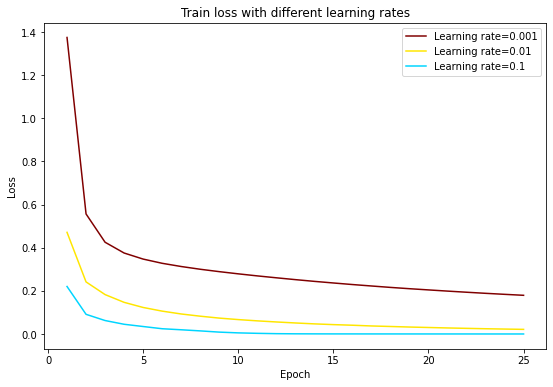

In [ ]:
plot_loss(t7_train_loss_series_arr, learning_rates, "Learning rate", "Train loss with different learning rates")

We see that the greater the learning rate, the faster the convergence for test loss.

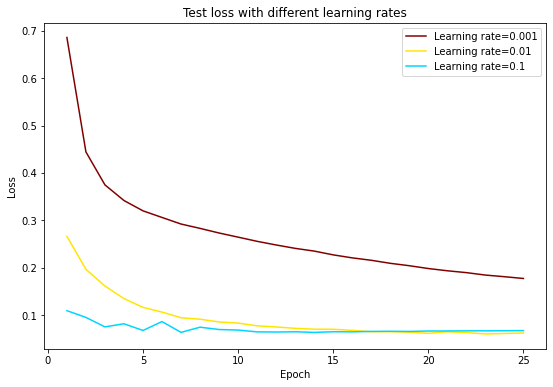

In [ ]:
plot_loss(t7_test_loss_series_arr, learning_rates, "Learning rate", "Test loss with different learning rates")

We see that learning rate=0.1 exhibits some oscillatory behaviour at first. This may be because the high learning rate causes the parameters to jump around in the parameter space since it is easier to escape local minima. Furthermore, we can see that the test error for learning rate 0.1 gradually surpassed that of 0.01. This may be because of overfitting, since this higher learning rate allows the model to learn faster in the sense that it can explore more of the parameter space when compared to lower learning rates (at the same number of epochs).

On the other hand, the test error for 0.001 is a lot higher than the other two. This is because it is taking too long for it to minimise the (empirical) loss function. It moves too slowly in the parameter space.

## Task 8: Compare the performance for small and large batch sizes

In [ ]:
def task(var_arr, print_kw, train_func):
  train_loss_series_arr = []
  test_loss_series_arr = []

  for var in var_arr:
    print(f"Current {print_kw}: {var}\n")
    train_loss, test_loss, test_error = train_func(var)
    train_loss_series_arr.append(train_loss)
    test_loss_series_arr.append(test_loss)
    print("\n")

  return train_loss_series_arr, test_loss_series_arr
  

Hyperparameters:
1. batch_size : bs
2. width : 64
3. depth : 1
4. learning rate : starts from 0.0015 and doubles each time batch size doubles
5. nepochs : 100 (or until training error < 0.02)
7. optimizer : optim.SGD
10. momentum : 0.95

I have chosen the learning rate to be proportional to batch size because to make a fair comparison, I would want each model to move (roughly) the same distance in the parameter space. Note that if the batch size is multiplied by $k$, the number of SGD steps is multiplied by a factor of around $\frac{1}{k}$. To offset this behavior, I multiply the step size by $k$.

In [ ]:
def task_8():
  batch_sizes_512 = [8, 16, 32, 64, 128, 256, 512]
  lrs = (0.03 / 20) * 2 ** np.arange(7)
  train_loss_series_arr = []
  test_loss_series_arr = []
  for bs, lr in zip(batch_sizes_512, lrs):
    print(f"Batch size: {bs}")
    print(f"Learning rate : {lr}")
    print("")
    train_loss, test_loss, test_error = train(batch_size=bs, width=64, depth=1, lr=lr, nepochs=100, print_freq=5, optimizer=optim.SGD, dp=6, trunc=0.02, momentum=0.95)
    train_loss_series_arr.append(train_loss)
    test_loss_series_arr.append(test_loss)
    print("\n")
  return train_loss_series_arr, test_loss_series_arr

In [ ]:
t8_train_loss_series_arr, t_8_test_loss_series_arr = task_8()

Batch size: 8
Learning rate : 0.0015

Epoch: 5 | Train Loss: 0.078293 | Test Loss: 0.087266 | Test Error: 0.0273
Epoch: 10 | Train Loss: 0.041896 | Test Loss: 0.077404 | Test Error: 0.0231
Epoch: 15 | Train Loss: 0.024288 | Test Loss: 0.080621 | Test Error: 0.0241
Epoch: 17 | Train Loss: 0.019407 | Test Loss: 0.075639 | Test Error: 0.0225


Batch size: 16
Learning rate : 0.003

Epoch: 5 | Train Loss: 0.080976 | Test Loss: 0.091476 | Test Error: 0.0283
Epoch: 10 | Train Loss: 0.043671 | Test Loss: 0.08011 | Test Error: 0.0235
Epoch: 15 | Train Loss: 0.025763 | Test Loss: 0.082748 | Test Error: 0.0249
Epoch: 18 | Train Loss: 0.018414 | Test Loss: 0.079643 | Test Error: 0.0226


Batch size: 32
Learning rate : 0.006

Epoch: 5 | Train Loss: 0.081356 | Test Loss: 0.087768 | Test Error: 0.0268
Epoch: 10 | Train Loss: 0.042684 | Test Loss: 0.076568 | Test Error: 0.0223
Epoch: 15 | Train Loss: 0.02474 | Test Loss: 0.086239 | Test Error: 0.0259
Epoch: 18 | Train Loss: 0.017489 | Test Loss: 0.080

| Batch size | Train Loss | Test Loss |
| --- | --- | --- |
| 8 | 0.019407 |  0.075639 |
|16|0.018414 | 0.079643
 |32|0.017489 | 0.080166
 |64 |0.018043 | 0.084046 
 |128 |  0.019301 | 0.084539
 |256 | 0.016848 | 0.086063 
 |512 | 0.019064 |0.087508



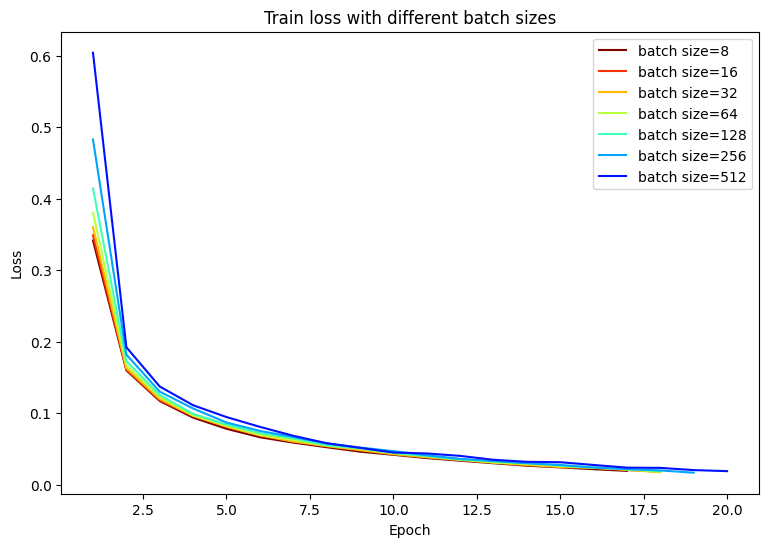

In [ ]:
batch_sizes_512 = [8, 16, 32, 64, 128, 256, 512]
plot_loss(t8_train_loss_series_arr, batch_sizes_512, "batch size", "Train loss with different batch sizes")

It seems like higher batch sizes lead to slower convergence in test loss despite the standardisation in learning rate mentioned above. This may be because for higher batch size, I have set the step size to be larger. This may cause the algorithm to "overshoot" and waste some of the steps.

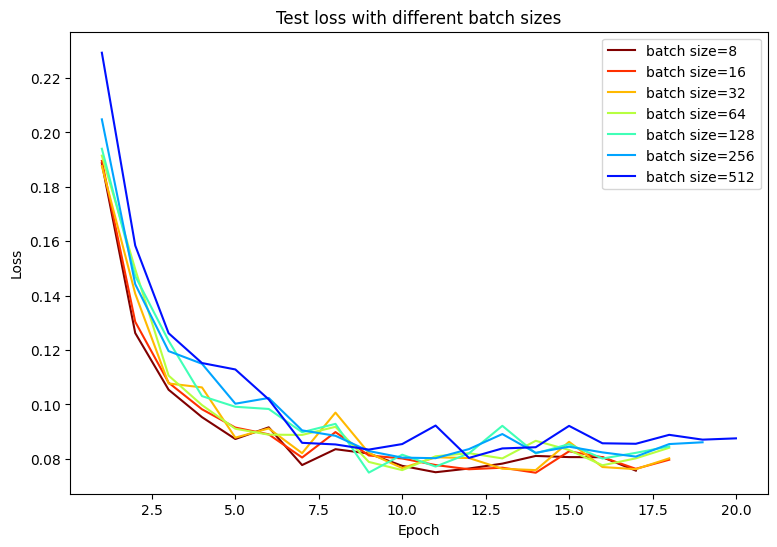

In [ ]:
plot_loss(t_8_test_loss_series_arr, batch_sizes_512, "batch size", "Test loss with different batch sizes")

There seems to be two trends here: Firstly we see the lines for batch size 32, 64, 128 to exhibit more variation than, say, 512. This is because lower batch size means there is more variance in each optimisation step, which may cause the algorithm to jump out of local minima more easily. Also, lower batch size means for each epoch, more optimisation steps are taken so there is a higher chance that they are at different minima between each epoch, which leads to different test performance.

On the other hand, batch size = 8, 16 seem to be relatively more stable, especially for higher epoch counts. This is because they take so many optimisation steps per epoch that it is likely to end up at a local minimum that is pretty stable/flat (because if not, it would have jumped out of it).

Text(0.5, 1.0, 'Generalisation error against batch size')

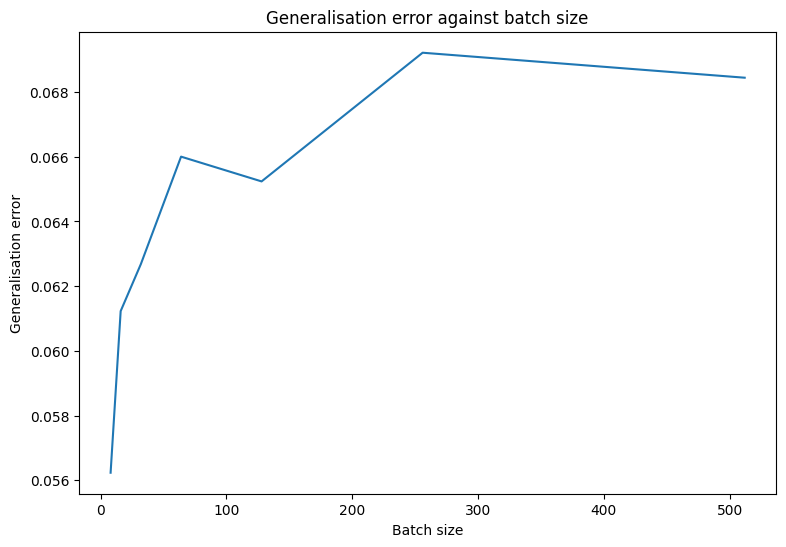

In [ ]:
generalisation_errors = [test[-1] - train[-1] for test, train in zip(t_8_test_loss_series_arr, t8_train_loss_series_arr)]
plt.plot(batch_sizes_512, generalisation_errors)
plt.xlabel("Batch size")
plt.ylabel("Generalisation error")
plt.title("Generalisation error against batch size")

Finally, we note that that the generalisation error increases with batch size. In Keskar et al., 2016, it is suggested that small batch size finds relatively flat minima large batch size finds relatively sharp minima. Flat minima generalise better than sharp ones. This agrees with the results shown in the graph above.

In terms of computational efficiency, higher batch size means we need to compute fewer gradients, so the algorithm trains faster

## Task 9: Analyse the train and test errors as a function of width

#### Uniform learning rate
Firstly, I tried to train models with different width keeping other hyperparameters, including learning rate, constant. However, I found that some models took longer than others to converge. I had to use different epoch count for different models (to save computation time).

Hyperparameters:
1. batch_size : 512
2. width : width
3. depth : 1
4. learning rate : 0.001
5. nepochs : nepochs


In [ ]:
width_arr = 2**np.arange(2, 11)
nepoch_arr = [20] * 4 + [27] + [19] + [15] * 3
input_arr = zip(width_arr, nepoch_arr)
task_9_wrapper = lambda tup : train(batch_size=512, width=tup[0], depth=1, lr=0.001, nepochs=tup[1], print_freq=5, optimizer=optim.Adam, dp=5)
t9_train_loss_series_arr, t_9_test_loss_series_arr = task(input_arr, "(width, max_epoch)", task_9_wrapper )

Current (width, max_epoch): (4, 20)

Epoch: 5 | Train Loss: 1.27458 | Test Loss: 1.22977 | Test Error: 0.4705
Epoch: 10 | Train Loss: 0.95217 | Test Loss: 0.94501 | Test Error: 0.2935
Epoch: 15 | Train Loss: 0.76871 | Test Loss: 0.76313 | Test Error: 0.2255
Epoch: 20 | Train Loss: 0.70917 | Test Loss: 0.70902 | Test Error: 0.206


Current (width, max_epoch): (8, 20)

Epoch: 5 | Train Loss: 0.40495 | Test Loss: 0.37539 | Test Error: 0.1031
Epoch: 10 | Train Loss: 0.32909 | Test Loss: 0.32252 | Test Error: 0.0885
Epoch: 15 | Train Loss: 0.30811 | Test Loss: 0.30824 | Test Error: 0.0862
Epoch: 20 | Train Loss: 0.29708 | Test Loss: 0.30149 | Test Error: 0.0828


Current (width, max_epoch): (16, 20)

Epoch: 5 | Train Loss: 0.28631 | Test Loss: 0.2716 | Test Error: 0.0758
Epoch: 10 | Train Loss: 0.22557 | Test Loss: 0.22353 | Test Error: 0.0647
Epoch: 15 | Train Loss: 0.19447 | Test Loss: 0.19999 | Test Error: 0.0595
Epoch: 20 | Train Loss: 0.17439 | Test Loss: 0.1822 | Test Error: 0.0554




| Width | Train Loss | Test Loss |
| --- | --- | --- |
|4| 0.70917 | 0.70902 |
| 8 | 0.29708 | 0.30149 |
|16| 0.17439 | 0.1822
 |32|0.11256 | 0.13168
 |64 | 0.04906 | 0.08624|
 |128 | 0.04095 |  0.07895
 |256 | 0.03444 | 0.06943
 |512 |  0.01947 | 0.06654
 |1024 | 0.00915 |  0.06143



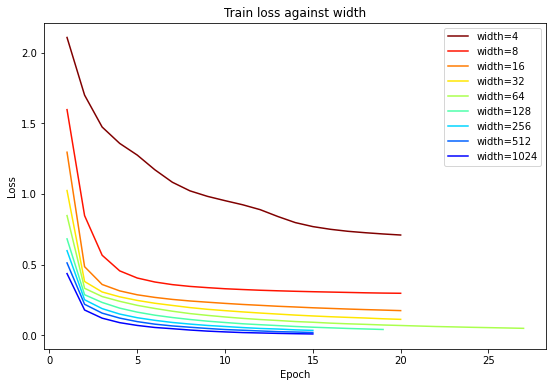

In [ ]:
plot_loss(t9_train_loss_series_arr, width_arr, "width", "Train loss against width")

We note that for depth <= 16, the train loss is quite high. This may be due to underparametrisation. 

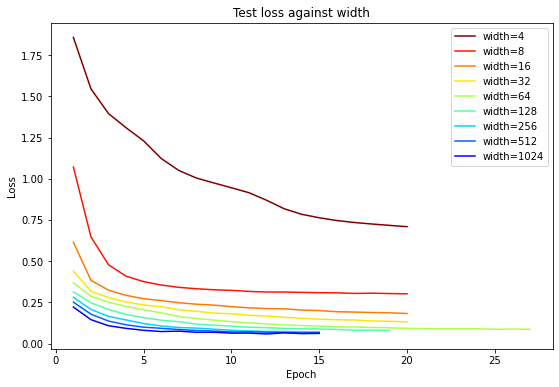

In [ ]:
plot_loss(t_9_test_loss_series_arr, width_arr, "width", "Test loss against width")

In [ ]:
train_losses_t9 = [arr[-1] for arr in t9_train_loss_series_arr]
test_losses_t9 = [arr[-1] for arr in t_9_test_loss_series_arr]

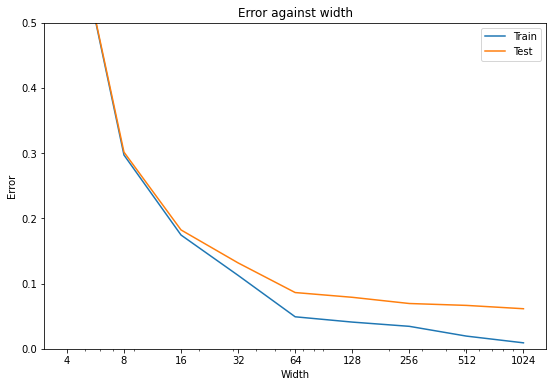

In [ ]:
plt.ylim(0, 0.5)
plt.xscale("log")
plt.xticks(width_arr, width_arr)
plt.plot(width_arr, train_losses_t9, label="Train")
plt.plot(width_arr, test_losses_t9, label="Test")
plt.xlabel("Width")
plt.ylabel("Error")
plt.title("Error against width")
plt.legend()

The graph looks roughly similar to the one presented in the coursework: Test loss indeed decreases with width. However, the gap between them seems a lot narrower. One reason might be the fact that in the original graph, the models were trained until convergence. However, using a uniform learning rate, it simply takes prohibitively long to train low width models to true convergence using my computer.

One alternative is to tweak the setup to allow learning rate to change with width, which we present below.

#### Learning rate dependent on width
Hyperparameters:
1. batch_size : 512
2. width : width
3. depth : 1
4. learning rate : [0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.002, 0.001]
5. nepochs : 15

The learning rates are chosen according to the heuristic as follows: smaller widths have a relatively small learning rate since the parameter space is smaller. Widths in the middle have a higher learning rate to explore more in the larger parameter space. Larger widths have a smaller learning rate, to compensate for the fact that vectors in higher dimensions have greater length in general.

NOTE : In the output below, (width, max_epoch) should be replaced by (width, learning rate). However, this is just a typo in the print statement (and does not affect the results). Since re-running this takes a long time, I am not able to do so.

In [ ]:
width_arr = 2**np.arange(2, 11)
lrs = [0.002] * 4 + [0.003] * 3 + [0.002] + [0.001]
input_arr = zip(width_arr, lrs)
task_9_wrapper = lambda tup : train(batch_size=512, width=tup[0], depth=1, lr=tup[1], nepochs=15, print_freq=5, optimizer=optim.Adam, dp=5)
t9_train_loss_series_arr2, t_9_test_loss_series_arr2 = task(input_arr, "(width, max_epoch)", task_9_wrapper )

Current (width, max_epoch): (4, 0.002)

Epoch: 5 | Train Loss: 0.93848 | Test Loss: 0.88065 | Test Error: 0.2577
Epoch: 10 | Train Loss: 0.75524 | Test Loss: 0.76526 | Test Error: 0.2283
Epoch: 15 | Train Loss: 0.72474 | Test Loss: 0.73939 | Test Error: 0.2189


Current (width, max_epoch): (8, 0.002)

Epoch: 5 | Train Loss: 0.33866 | Test Loss: 0.32546 | Test Error: 0.0912
Epoch: 10 | Train Loss: 0.30222 | Test Loss: 0.30686 | Test Error: 0.0841
Epoch: 15 | Train Loss: 0.2884 | Test Loss: 0.29948 | Test Error: 0.0829


Current (width, max_epoch): (16, 0.002)

Epoch: 5 | Train Loss: 0.24224 | Test Loss: 0.2363 | Test Error: 0.0679
Epoch: 10 | Train Loss: 0.18919 | Test Loss: 0.19282 | Test Error: 0.0584
Epoch: 15 | Train Loss: 0.16039 | Test Loss: 0.18406 | Test Error: 0.0558


Current (width, max_epoch): (32, 0.002)

Epoch: 5 | Train Loss: 0.1906 | Test Loss: 0.1861 | Test Error: 0.0539
Epoch: 10 | Train Loss: 0.12697 | Test Loss: 0.14475 | Test Error: 0.0418
Epoch: 15 | Train Loss: 0.

| Width | Train Loss | Test Loss |
| --- | --- | --- |
|4| 0.72474 | 0.73939
| 8 | 0.2884 |  0.29948 |
|16| 0.16039 | 0.18406
 |32|0.09499 | 0.12063
 |64 |  0.04178 |  0.09166
 |128 | 0.01567 | 0.07519
 |256 | 0.00709 |  0.06834
 |512 | 0.00768 |  0.07068
 |1024 | 0.00915 |  0.06143



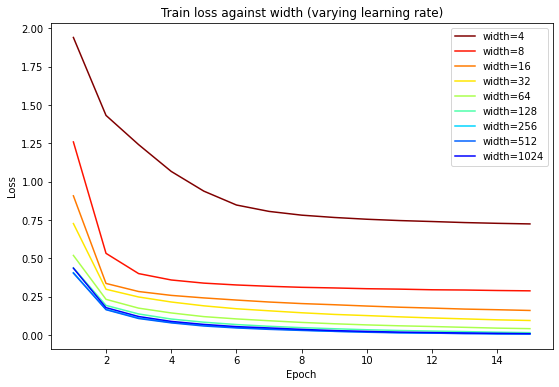

In [ ]:
plot_loss(t9_train_loss_series_arr2, width_arr, "width", "Train loss against width (varying learning rate)")

Again, we see that width <= 16 has high train loss due to under parametrisation

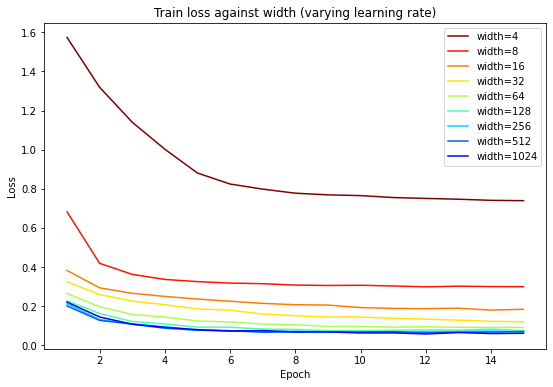

In [ ]:
plot_loss(t_9_test_loss_series_arr2, width_arr, "width", "Train loss against width (varying learning rate)")

In [ ]:
train_losses_t92 = [arr[-1] for arr in t9_train_loss_series_arr2]
test_losses_t92 = [arr[-1] for arr in t_9_test_loss_series_arr2]

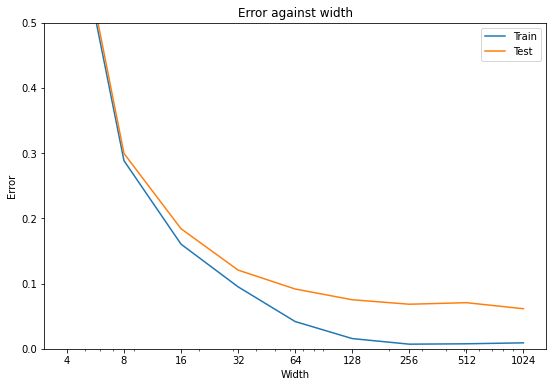

In [ ]:
plt.ylim(0, 0.5)
plt.xscale("log")
plt.xticks(width_arr, width_arr)
plt.plot(width_arr, train_losses_t92, label="Train")
plt.plot(width_arr, test_losses_t92, label="Test")
plt.xlabel("Width")
plt.ylabel("Error")
plt.title("Error against width")
plt.legend()

Note that we observe the same phenomenon (i.e. more parameters can result in a lower test loss) across both trials (uniform and non-uniform learning rate).

In Neyshabur et al., 2018, the authors propose tighter generalisation bounds for two layer ReLU networks which decreases with an increasing number of hidden units. This might prove to be useful in explaining the observed trend above.

## Task 10: Test the performance on CIFAR10

In [ ]:
import torchvision.transforms as T

We now train the net on the CIFAR10 dataset using 

Hyperparameters:
1. batch_size : 256
2. width : 512
3. depth : 3
4. learning rate : 0.0003
5. nepochs : 100


In [ ]:
train(batch_size=256, width=512, depth=3, lr=0.0003, nepochs=100, print_freq=5, optimizer=optim.Adam, dataset="CIFAR10", output="None")

Epoch: 5 | Train Loss: 1.495 | Test Loss: 1.476 | Test Error: 0.53
Epoch: 10 | Train Loss: 1.335 | Test Loss: 1.416 | Test Error: 0.503
Epoch: 15 | Train Loss: 1.205 | Test Loss: 1.335 | Test Error: 0.473
Epoch: 20 | Train Loss: 1.093 | Test Loss: 1.325 | Test Error: 0.466
Epoch: 25 | Train Loss: 0.976 | Test Loss: 1.345 | Test Error: 0.462
Epoch: 30 | Train Loss: 0.868 | Test Loss: 1.341 | Test Error: 0.447
Epoch: 35 | Train Loss: 0.753 | Test Loss: 1.419 | Test Error: 0.452
Epoch: 40 | Train Loss: 0.655 | Test Loss: 1.457 | Test Error: 0.452
Epoch: 45 | Train Loss: 0.537 | Test Loss: 1.596 | Test Error: 0.451
Epoch: 50 | Train Loss: 0.445 | Test Loss: 1.717 | Test Error: 0.453
Epoch: 55 | Train Loss: 0.355 | Test Loss: 1.98 | Test Error: 0.46
Epoch: 60 | Train Loss: 0.302 | Test Loss: 2.042 | Test Error: 0.453
Epoch: 65 | Train Loss: 0.23 | Test Loss: 2.225 | Test Error: 0.453
Epoch: 70 | Train Loss: 0.207 | Test Loss: 2.422 | Test Error: 0.46
Epoch: 75 | Train Loss: 0.129 | Test Los

The final results are as follows:

Train Loss: 0.106 | Test Loss: 3.48 | Test Error: 0.474

I think it is more difficult to learn the dataset CIFAR10 than MINST. The former is a dataset made of 10 classes, including cats, frogs, planes etc. The latter is a dataset of 10 classes of digits 0-9. The former can be more difficult, because within the same class there is greater variety, for example, there are many different kinds of cats. In contrast, the digits look, relatively speaking, more similar within the same class. Furthermore, the CIFAR10 dataset has a background while MINST does not, which may confuse the algorithm.

## Bonus task 

Firstly, we apply various random transformations to the images before each epoch.
The transformations include:

  1. Random affine
  2. Color Jitter
  3. Random rotations
  4. Random horizonal flips
  5. Random grayscale
  6. Random perspective
  7. Random autocontrast

The idea is that after applying these transformations, the image should still belong to the same class. While a human knows that if a cat is flipped horizonally / rotated a bit etc, the result should still be a cat; this notion may not be clear to the net. By introducing these transformations and keeping the same label, we can try to make the net learn these properties.


In [ ]:
import torchvision.transforms as T
rand_transforms = [T.RandomAffine(degrees=45, translate=(0, 0.05), scale=(0.8, 1), shear=10), 
                   T.transforms.ColorJitter(brightness=.5, hue=0.2),
                   T.RandomAffine(degrees=45),
                   ]
p_arr = [0.5, 1, 0.5]

CIFAR10_train_set = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=True,
transform=transforms.Compose([transforms.ToTensor(), 
                              T.RandomAutocontrast(0.1),
                              T.RandomApply([T.RandomChoice(rand_transforms, p=p_arr)], 0.1), 
                              T.RandomHorizontalFlip(0.5),
                              T.RandomGrayscale(0.1),
                              T.RandomPerspective(distortion_scale=0.2, p=0.05)                              
                              ]
                             )
)

CIFAR10_test_set = torchvision.datasets.CIFAR10(
root="./",
download=True,
train=False,
transform=transforms.Compose([transforms.ToTensor()])
)


Files already downloaded and verified
Files already downloaded and verified


We train a net using the above transformations and the hyperparameters below:

1. batch_size : 256
2. width : 512
3. depth : 3
4. learning rate : 0.0003
5. nepochs : 100

#### Achieved accuracy: around 0.565

We can see that after epoch 29, the test error stays below 0.45, which means we have achieved accuracy above 0.55 as required.

In [ ]:
train(batch_size=256, width=512, depth=3, lr=0.0003, nepochs=100, print_freq=1, optimizer=optim.Adam, dataset=(CIFAR10_train_set, CIFAR10_test_set))

Epoch: 1 | Train Loss: 1.975 | Test Loss: 1.802 | Test Error: 0.643
Epoch: 2 | Train Loss: 1.787 | Test Loss: 1.689 | Test Error: 0.612
Epoch: 3 | Train Loss: 1.704 | Test Loss: 1.609 | Test Error: 0.575
Epoch: 4 | Train Loss: 1.638 | Test Loss: 1.58 | Test Error: 0.56
Epoch: 5 | Train Loss: 1.59 | Test Loss: 1.497 | Test Error: 0.531
Epoch: 6 | Train Loss: 1.55 | Test Loss: 1.474 | Test Error: 0.523
Epoch: 7 | Train Loss: 1.527 | Test Loss: 1.458 | Test Error: 0.521
Epoch: 8 | Train Loss: 1.502 | Test Loss: 1.434 | Test Error: 0.508
Epoch: 9 | Train Loss: 1.473 | Test Loss: 1.533 | Test Error: 0.538
Epoch: 10 | Train Loss: 1.455 | Test Loss: 1.381 | Test Error: 0.492
Epoch: 11 | Train Loss: 1.435 | Test Loss: 1.373 | Test Error: 0.489
Epoch: 12 | Train Loss: 1.412 | Test Loss: 1.357 | Test Error: 0.478
Epoch: 13 | Train Loss: 1.392 | Test Loss: 1.352 | Test Error: 0.484
Epoch: 14 | Train Loss: 1.374 | Test Loss: 1.372 | Test Error: 0.487
Epoch: 15 | Train Loss: 1.364 | Test Loss: 1.33

([1.9754651192474366,
  1.7874585348129273,
  1.7038619025421142,
  1.6376621642303466,
  1.58970316986084,
  1.5504832341766357,
  1.5265636994934082,
  1.5017651961517333,
  1.4733832565307616,
  1.4549980591583251,
  1.4347197548675537,
  1.4118809997940063,
  1.391752211074829,
  1.374093849105835,
  1.363630073776245,
  1.3428448731994629,
  1.3363459135437012,
  1.3146519403839112,
  1.3002426538085938,
  1.2851063621520995,
  1.2750297986602783,
  1.2630382989120483,
  1.249443950920105,
  1.2335456339263915,
  1.2226837618637085,
  1.204150132713318,
  1.2010573273468017,
  1.1797310186767578,
  1.1677851941680908,
  1.1620938166046142,
  1.1414123260498046,
  1.1411156823730468,
  1.1165612550354005,
  1.1081733916091918,
  1.0975163759613038,
  1.0847801213264465,
  1.0805264471817018,
  1.070205657081604,
  1.04553624250412,
  1.0405217915534972,
  1.0334653364181519,
  1.0194928679656983,
  1.0127075053024293,
  1.003179454536438,
  0.9886920932388306,
  0.9766778155517578,